In [1]:
import glob
import os 
import string
from pathlib import Path

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt

from utils.utils import strLabelConverter, decode_prediction
from utils.plotting import plot_loss, print_prediction
from layers import blockCNN, blockRNN

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

In [3]:
%matplotlib inline
plt.style.use('seaborn')

#### <center>  Dataset

In [4]:
class CaptchaDataset(Dataset):
    def __init__(self, img_dir: str):
        self.img_dir = img_dir
        pathes = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)
        self.pathes = [os.path.join(abspath, path) for path in pathes]
        self.list_transforms = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return len(self.pathes)
    
    def __getitem__(self, idx):
        path = self.pathes[idx]
        text = self.get_filename(path)
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, text
    
    def get_filename(self, path: str) -> str:
        return os.path.basename(path).split('.')[0].lower().strip()
    
    def transform(self, img) -> torch.Tensor:
        return self.list_transforms(img)

<center> Dataset Params

In [12]:
TRAIN_DIR = Path('data/train')
VAL_DIR = Path('data/val')
BATCH_SIZE = 8
MODEL_PATH = Path('models/crnn.pt')
N_WORKERS = 4

In [37]:
batch_imgs.dtype

torch.float32

In [13]:
alphabet = string.ascii_lowercase + string.digits
label_converter = strLabelConverter(alphabet)
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789'

In [14]:
train_dataset = CaptchaDataset(TRAIN_DIR)
val_dataset = CaptchaDataset(VAL_DIR)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                              num_workers=N_WORKERS, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                            num_workers=N_WORKERS, shuffle=False)

In [15]:
imgs, texts = iter(val_dataloader).next()
print(imgs.shape, len(texts))

torch.Size([8, 3, 50, 200]) 8


#### <center> Model

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [18]:
class CRNN(nn.Module):
    def __init__(self, hidden_size: int, 
                 vocab_size: int, 
                 bidirectional: bool = True, 
                 dropout: float = 0.5):
        super(CRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.bidirectional = bidirectional
        # make layers
        # convolutions 
        resnet = resnet18(pretrained=True)
        modules = list(resnet.children())[:-3]
        self.resnet = nn.Sequential(*modules)

        self.cn6 = blockCNN(256, 256, kernel_size=3, padding=1)
        # RNN + Linear
        self.linear1 = nn.Linear(1024, 256)
        self.gru1 = blockRNN(256, hidden_size, hidden_size,
                             dropout=dropout, 
                             bidirectional=bidirectional)
        self.gru2 = blockRNN(hidden_size, hidden_size, vocab_size,
                             dropout=dropout,
                             bidirectional=bidirectional)
        self.linear2 = nn.Linear(hidden_size * 2, vocab_size)
        # initialize weights
        #self.apply(weights_init)
        
    def forward(self, batch: torch.Tensor):
        """
        ------:size sequence:------
        torch.Size([batch_size, 3, 50, 200]) -- IN:
        torch.Size([batch_size, 32, 6, 25]) -- CNN blocks ended
        torch.Size([batch_size, 25, 32, 6]) -- permuted 
        torch.Size([batch_size, 25, 192]) -- Linear #1
        torch.Size([batch_size, 20, 32]) -- IN GRU 
        torch.Size([batch_size, 20, 256]) -- OUT GRU 
        torch.Size([batch_size, 20, vocab_size]) -- Linear #2
        torch.Size([20, batch_size, vocab_size]) -- :OUT
        """
        batch_size = batch.size(0)
        # convolutions
        batch = self.resnet(batch)
        batch = self.cn6(batch, use_relu=True, use_bn=True)
        # make sequences of image features
        batch = batch.permute(0, 3, 1, 2)
        n_channels = batch.size(1)
        #print(batch.size())
        batch = batch.view(batch_size, n_channels, -1)
        #print(batch.size())
        batch = self.linear1(batch)
        # rnn layers
        batch = self.gru1(batch, add_output=True)
        batch = self.gru2(batch)
        # output
        batch = self.linear2(batch)
        batch = batch.permute(1, 0, 2)
        return batch

#### <center>  Model Parameters and Initialization

In [19]:
hidden_size = 256
vocab_size = len(alphabet) + 1
bidirectional = True
dropout = 0.1
weight_decay = 1e-5
momentum = 0.9
clip_norm = 5
max_epoch = 50
print(vocab_size)

37


In [20]:
crnn = CRNN(hidden_size=hidden_size, vocab_size=vocab_size, 
            bidirectional=bidirectional, dropout=dropout).to(device)
crnn(imgs.to(device)).shape

torch.Size([13, 8, 37])

In [21]:
lr = 0.02
optimizer = torch.optim.SGD(crnn.parameters(), lr=lr, nesterov=True, 
                            weight_decay=weight_decay, momentum=momentum)
critertion = nn.CTCLoss(blank=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [22]:
def validation(model, val_losses, label_converter):
    with torch.no_grad():
        model.eval()
        for batch_img, batch_text in val_dataloader:
            logits = crnn(batch_img.to(device))
            val_loss = calculate_loss(logits, batch_text, label_converter)
            val_losses.append(val_loss.item())
    return val_losses

In [23]:
def acc_calc(model, dataset, label_converter) -> float:
    acc = 0
    with torch.no_grad():
        model.eval()
        for idx in range(len(dataset)):
            img, text = dataset[idx]
            logits = model(img.unsqueeze(0).to(device))
            pred_text = decode_prediction(logits.cpu(), label_converter)
            
            if pred_text == text:
                acc += 1
            
    return acc / len(dataset)

In [24]:
def calculate_loss(logits, texts, label_converter):
    # get infomation of prediction
    device = logits.device
    input_len, batch_size, vocab_size = logits.size()
    # encode inputs
    logits = logits.log_softmax(2)
    encoded_texts, text_lens = label_converter.encode(texts)
    logits_lens = torch.full(size=(batch_size,), fill_value=input_len, dtype=torch.int32)
    # calculate ctc
    loss = critertion(logits, encoded_texts, 
                      logits_lens.to(device), text_lens)
    return loss

#### <center> Training

In [25]:
epoch = 0

In [26]:
train_losses = []
val_losses = []
val_epoch_len = len(val_dataset) // BATCH_SIZE
val_epoch_len

26

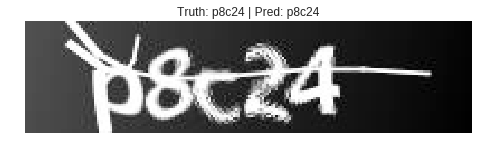

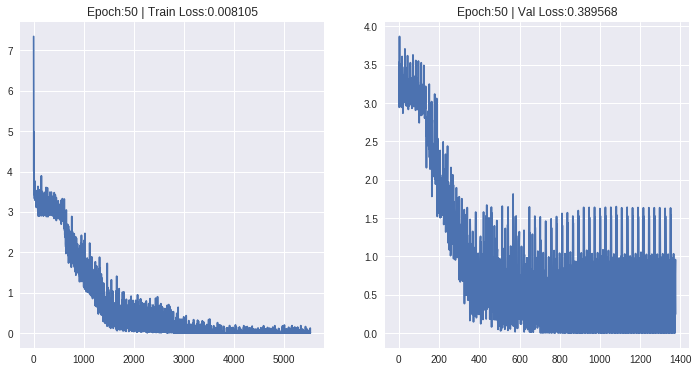

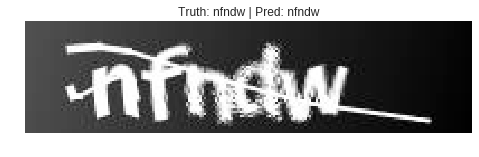

In [33]:
try:
    while epoch <= max_epoch:
        crnn.train()
        for idx, (batch_imgs, batch_text) in enumerate(train_dataloader):
            optimizer.zero_grad()
            logits = crnn(batch_imgs.to(device))
            # calculate loss
            train_loss = calculate_loss(logits, batch_text, label_converter)
            if np.isnan(train_loss.detach().cpu().numpy()):
                continue
            train_losses.append(train_loss.item())
            # make backward
            train_loss.backward()

            nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
            optimizer.step()

        val_losses = validation(crnn, val_losses, label_converter)
        
        # printing progress
        plot_loss(epoch, train_losses, val_losses)
        print_prediction(crnn, val_dataset, device, label_converter)
        
        scheduler.step(val_losses[-1])
        epoch += 1
except KeyboardInterrupt:
    pass

In [28]:
torch.save(crnn.state_dict(), MODEL_PATH)

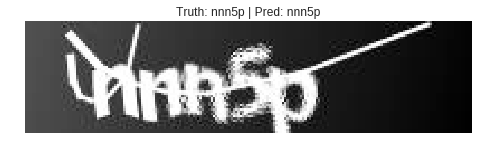

In [30]:
print_prediction(crnn, val_dataset, device, label_converter)

In [34]:
val_acc = acc_calc(crnn, val_dataset, label_converter)
train_acc = acc_calc(crnn, train_dataset, label_converter)
print('Validaton Accuracy: ', val_acc)
print('Training Accuracy: ', train_acc)

Validaton Accuracy:  0.8364485981308412
Training Accuracy:  0.9287383177570093
